In [1]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/MyDrive/summer\ project

/content/drive/MyDrive/summer project


In [3]:
!pip install -U torch torchvision
!pip install git+https://github.com/facebookresearch/fvcore.git
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/fvcore.git to /tmp/pip-req-build-fdq0rj1l
  Running command git clone -q https://github.com/facebookresearch/fvcore.git /tmp/pip-req-build-fdq0rj1l
     |████████████████████████████████| 636 kB 5.3 MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5-py3-none-any.whl size=64542 sha256=92de783fa7f9fcd5cd36cc64442ca047fb11b6b8666f67edb2872cd369daf5b6
  Stored in directory: /tmp/pip-ephem-wheel-cache-0ex81rsn/wheels/24/1d/09/8167de727fe5b74f832b6fcb5d9069d8f03ca29f337bfe484d
Successfully built fvcore
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
fatal: destination path 'detectron2_repo' already exists and is not an empty directory.
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-gte88h6i
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-gte88h6i
     |██

In [4]:
import cv2
import random
from detectron2.utils.visualizer import Visualizer
import cv2 as cv2
from google.colab.patches import cv2_imshow
import os

In [5]:
def MetaAndData(name):
  metadata = MetadataCatalog.get(name)
  dicts = DatasetCatalog.get(name)
  return metadata, dicts

In [6]:
from detectron2.data.datasets import register_coco_instances
from detectron2.data import *
register_coco_instances("train3", {}, r"/content/drive/MyDrive/summer project/coco/train/label/coco.json", r"/content/drive/MyDrive/summer project/coco/train")
register_coco_instances("val3", {}, r"/content/drive/MyDrive/summer project/coco/val/label/coco.json", r"/content/drive/MyDrive/summer project/coco/val")
train_metadata,train_dicts = MetaAndData('train3')
val_metadata,val_dicts = MetaAndData('val3')

In [22]:
import numpy as np
a = np.random.normal(4,4,(4,2))

In [26]:
a = a.tolist()

In [27]:
np.max(a,axis = 0)

array([ 8.4408972 , 10.17031564])

In [28]:
train_metadata

Metadata(evaluator_type='coco', image_root='/content/drive/MyDrive/summer project/coco/train', json_file='/content/drive/MyDrive/summer project/coco/train/label/coco.json', name='train3', thing_classes=['container', 'dent', 'severe damage'], thing_dataset_id_to_contiguous_id={1: 0, 2: 1, 3: 2})

In [ ]:
# # Since My training set and test set labels doesn't match
# for idx in range(len(val_dicts)):
#   for anno in range(len(val_dicts[idx]['annotations'])):
#     if val_dicts[idx]['annotations'][anno]['category_id']==0:
#         val_dicts[idx]['annotations'][anno]['category_id'] = 1
#     elif val_dicts[idx]['annotations'][anno]['category_id']==1:
#         val_dicts[idx]['annotations'][anno]['category_id'] = 0

In [ ]:
# for i in train_dicts:
#   print(i[0])
# train_dicts[1]

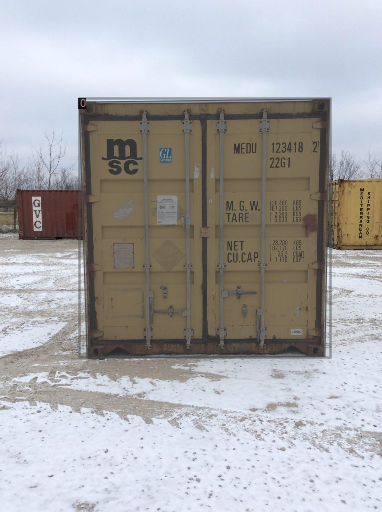

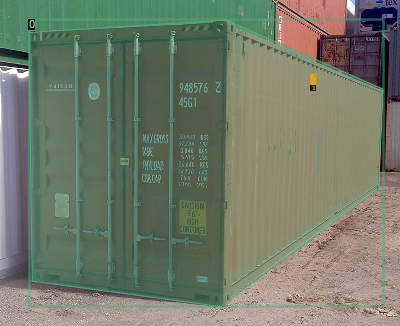

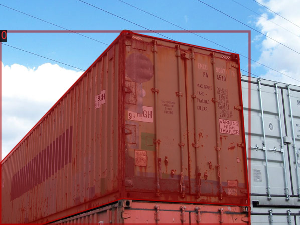

In [29]:
for d in random.sample(val_dicts, 3):
# for d in train_dicts:
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import detectron2.data.transforms as T
from detectron2.data import DatasetMapper
import os

In [ ]:
cfg = get_cfg()

In [ ]:
cfg.MODEL.ANCHOR_GENERATOR.ASPECT_RATIOS 

[[0.5, 1.0, 2.0]]

In [ ]:
###################
#Setting the config
###################

from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file(
    "./detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
)
########################
#         WEIGHTS.     #
########################

## Retrain
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  # initialize from model zoo


### Continue my training
# cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth") 


###################
#.  Other Config  #
###################
cfg.DATASETS.TRAIN = ("train3",)
cfg.DATASETS.TEST = ()  # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 2
cfg.OUTPUT_DIR = './output_8_22'
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.002
cfg.SOLVER.MAX_ITER = (2000)  # 300 iterations seems good enough, but you can certainly train longer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = (
    64
)  # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4  # 3 classes (data, fig, hazelnut)
cfg.SOLVER.CHECKPOINT_PERIOD = 400
# cfg.TEST.EVAL_PERIOD =50

In [ ]:
class MyTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        mapper = DatasetMapper(cfg, is_train=True, augmentations=[
                              T.RandomBrightness(0.9, 1.1),
                              T.RandomFlip(prob=0.5),
                              T.RandomApply(T.RandomRotation(15),0.8)]
                              )
        
        return build_detection_train_loader(cfg, mapper=mapper)

In [ ]:
#Training
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = MyTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[08/21 23:25:24 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:01, 89.8MB/s]                          
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (5, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (5,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (16, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (16,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to 

[08/21 23:25:28 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


ERROR [08/21 23:25:31 d2.engine.train_loop]: Exception during training:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/detectron2/engine/train_loop.py", line 149, in train
    self.run_step()
  File "/usr/local/lib/python3.7/dist-packages/detectron2/engine/defaults.py", line 499, in run_step
    self._trainer.run_step()
  File "/usr/local/lib/python3.7/dist-packages/detectron2/engine/train_loop.py", line 285, in run_step
    losses.backward()
  File "/usr/local/lib/python3.7/dist-packages/torch/_tensor.py", line 255, in backward
    torch.autograd.backward(self, gradient, retain_graph, create_graph, inputs=inputs)
  File "/usr/local/lib/python3.7/dist-packages/torch/autograd/__init__.py", line 149, in backward
    allow_unreachable=True, accumulate_grad=True)  # allow_unreachable flag
RuntimeError: CUDA out of memory. Tried to allocate 940.00 MiB (GPU 0; 14.76 GiB total capacity; 12.89 GiB already allocated; 573.75 MiB free; 13.12 GiB reserved in tota

RuntimeError: ignored

In [ ]:
import tensorboard
%reload_ext tensorboard
%tensorboard --logdir output

# Prediction

In [ ]:
cfg.OUTPUT_DIR ='./output'

In [ ]:
cfg.OUTPUT_DIR

In [ ]:
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data import build_detection_train_loader
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_0004999.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3   # set the testing threshold for this model
cfg.DATASETS.TEST = ("train1")
predictor = DefaultPredictor(cfg)

In [ ]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(train_dicts, 1):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=train_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    vis = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(vis.get_image()[:, :, ::-1])
    v = Visualizer(im[:, :, ::-1],
                   metadata=val_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    vis = v.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [ ]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(val_dicts, 20):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=val_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    vis = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(vis.get_image()[:, :, ::-1])
    v = Visualizer(im[:, :, ::-1],
                   metadata=val_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    vis = v.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [ ]:
# 数据增强
from detectron2.data import build_detection_train_loader
from detectron2.data import transforms as T
from detectron2.data import detection_utils as utils

def mapper(dataset_dict):
 # 自定义mapper
 dataset_dict = copy.deepcopy(dataset_dict)  # 后面要改变这个dict，所以先复制
 image = utils.read_image(dataset_dict["file_name"], format="BGR")  # 读取图片，numpy array
 image, transforms = T.apply_transform_gens([T.Resize((800, 800))], image)  # 数组增强
 dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32")) # 转成Tensor

 annos = [
  utils.transform_instance_annotations(obj, transforms, image.shape[:2])
  for obj in dataset_dict.pop("annotations")
  if obj.get("iscrowd", 0) == 0
 ] # 数据增强要同步标注
 instances = utils.annotations_to_instances(annos, image.shape[:2])  # 将标注转成Instance（Tensor）
 dataset_dict["instances"] = utils.filter_empty_instances(instances)  # 去除空的
 return dataset_dict

data_loader = build_detection_train_loader(cfg, mapper=mapper)

In [ ]:
data_loader

In [ ]:
d

In [ ]:
d = dataset_dicts[0]
image = cv2.imread(d["file_name"])
boxes = [d0['box'] for d0 in d]

In [ ]:
import numpy as np
a = d['annotations']
boxes = np.array([a[d0]['bbox'] for d0 in range(len(a))])
seg = np.array([d0['segmentation'] for d0 in a])

In [ ]:
input = T.AugInput(image)
transform = augs(input)

In [ ]:
from detectron2.data import transforms as T
# Define a sequence of augmentations:
augs = T.AugmentationList([
    T.RandomBrightness(0.9, 1.1),
    T.RandomFlip(prob=0.5),
])  # type: T.Augmentation

# Define the augmentation input ("image" required, others optional):
input = T.AugInput(image, boxes=boxes, sem_seg=seg)
# Apply the augmentation:
transform = augs(input)  # type: T.Transform
image_transformed = input.image  # new image
sem_seg_transformed = input.sem_seg  # new semantic segmentation

# For any extra data that needs to be augmented together, use transform, e.g.:
# image2_transformed = transform.apply_image(image2)
# polygons_transformed = transform.apply_polygons(polygons)

In [ ]:
image[0,:5], image[0,:5]

In [ ]:
sem_seg_transformed, seg